In [52]:
from pythtb import *
import numpy as np
from tqdm import tqdm  as tqdm
import matplotlib.pyplot as plt

In [53]:
def get_model(delta=0.2,theta=np.pi/2,d=0):
    lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
    orb=[[1./3.,1./3.],[2./3.,2./3.]]

    my_model=tb_model(2,2,lat,orb)

    t=-1.0
    t2 =.1*np.exp((1.j)*theta)
    t2c=t2.conjugate()

    # set on-site energies
    my_model.set_onsite([-delta+d,delta+d])
    my_model.set_hop(t, 0, 1, [ 0, 0])
    my_model.set_hop(t, 1, 0, [ 1, 0])
    my_model.set_hop(t, 1, 0, [ 0, 1])
    my_model.set_hop(t2 , 0, 0, [ 1, 0])
    my_model.set_hop(t2 , 1, 1, [ 1,-1])
    my_model.set_hop(t2 , 1, 1, [ 0, 1])
    my_model.set_hop(t2c, 1, 1, [ 1, 0])
    my_model.set_hop(t2c, 0, 0, [ 1,-1])
    my_model.set_hop(t2c, 0, 0, [ 0, 1])
    return my_model

In [56]:
# get evec for model
def get_wav(my_model,nk=10):
    k_vec = my_model.k_uniform_mesh([nk,nk])
    evals,evec=my_model.solve_all(k_vec,eig_vectors=True)
    return evec

#reshape evec in nk,nk,(nbnd/2 * norb *2) [*2 for real and im part]
def reshape_evec(evec,phase=True):
    nk=int(np.sqrt(evec.shape[1]))
    nbnd=norb=evec.shape[0]
    evec=np.swapaxes(evec,0,1)
    evec_new=evec.reshape(nk,nk,nbnd,norb)
    a=[]
    b=[]
    for i in range(int(nbnd/2)):
        for j in range(norb):
            if phase:
                a.append(np.angle(evec_new[:,:,i,j]))
                a.append(np.absolute(evec_new[:,:,i,j]))
            else:
                a.append(np.real(evec_new[:,:,i,j]))
                a.append(np.imag(evec_new[:,:,i,j]))
                
    a=np.array(a).T
    return a
def get_chern(my_model,nk=8):
    nkx=nky=nk
    kx=np.linspace(-0.5,0.5,num=nkx)
    ky=np.linspace(-0.5,0.5,num=nky)
    my_array_2=wf_array(my_model,[nkx,nky])
    # solve model at all k-points
    for i in range(nkx):
        for j in range(nky):
            (eval,evec)=my_model.solve_one([kx[i],ky[j]],eig_vectors=True)
            # store wavefunctions
            my_array_2[i,j]=evec
    my_array_2.impose_pbc(0,0)
    my_array_2.impose_pbc(1,1)
    return np.round(my_array_2.berry_flux([0])/(2*np.pi))

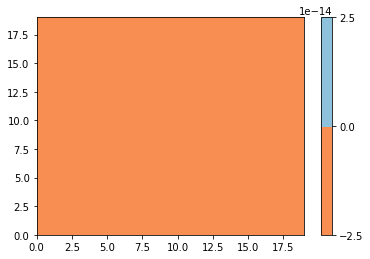

In [426]:
my_model=get_model(delta=.9,theta=np.pi/2)
evec=get_wav(my_model,nk)
z=reshape_evec(evec,phase=False)
plt.contourf(z[:,:,1],cmap="RdYlBu")
plt.colorbar()

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import time

# data creation

In [1026]:
def process_y(Y):
    from sklearn import preprocessing
    enc = preprocessing.OneHotEncoder()
    enc.fit(np.array(Y).reshape(-1, 1))
    return enc,enc.transform(np.array(Y).reshape(-1, 1)).toarray()

In [1057]:
nk=10
num=200
norb=get_model().get_num_orbitals()
X=np.zeros((num,nk,nk,norb*norb))
Y=[]
choosen_t=[]
choosen_theta=[]
for i,j in tqdm(enumerate(np.linspace(0,1,num))):
    theta=np.random.uniform(low=0, high=2*np.pi)
    t=np.random.uniform(low=-.2, high=.2)
    my_model=get_model(delta=t,theta=theta)
    evec=get_wav(my_model,nk)
    X[i]=reshape_evec(evec,phase=False)
    Y.append(get_chern(my_model))
    choosen_t.append(t)
    choosen_theta.append(theta)
#[band,kpoint,orbital]

In [1058]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
encoder,y_train = process_y(y_train)
_,y_test = process_y(y_test)

In [1034]:
cnn = Sequential()

cnn = Sequential()
cnn.add(Conv2D(filters=10, 
               kernel_size=(2,2), 
               strides=(1,1),
               padding='same',
               input_shape=(nk,nk,int(norb/2 * norb)*2),
               data_format='channels_last'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Conv2D(filters=10,
               kernel_size=(2,2),
               strides=(1,1),
               padding='valid'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),
                     strides=2))
cnn.add(Flatten())        
cnn.add(Dense(10))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(2))
cnn.add(Activation('sigmoid'))



cnn.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [523]:
start = time.time()
history=cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)
end = time.time()
print('Processing time:',(end - start)/60)
cnn.save_weights('cnn_baseline.h5')

Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 0s 473us/step - loss: 0.2347 - accuracy: 0.8600 - val_loss: 0.1301 - val_accuracy: 0.9750
Epoch 2/20
400/400 [==============================] - 0s 214us/step - loss: 0.2044 - accuracy: 0.8712 - val_loss: 0.1084 - val_accuracy: 0.9700
Epoch 3/20
400/400 [==============================] - 0s 222us/step - loss: 0.1972 - accuracy: 0.8612 - val_loss: 0.0978 - val_accuracy: 0.9650
Epoch 4/20
400/400 [==============================] - 0s 200us/step - loss: 0.1838 - accuracy: 0.8700 - val_loss: 0.0892 - val_accuracy: 0.9650
Epoch 5/20
400/400 [==============================] - 0s 226us/step - loss: 0.1668 - accuracy: 0.8763 - val_loss: 0.0815 - val_accuracy: 0.9600
Epoch 6/20
400/400 [==============================] - 0s 203us/step - loss: 0.1833 - accuracy: 0.8550 - val_loss: 0.0775 - val_accuracy: 0.9600
Epoch 7/20
400/400 [==============================] - 0s 195us/step - loss: 0.1581 - accur

In [1060]:
model = Sequential()
model.add(Conv2D(10, kernel_size=2, activation="relu", input_shape=(nk,nk,int(norb/2 * norb)*2)))
model.add(Dropout(0.4))
model.add(Conv2D(5, kernel_size=2, activation="relu"))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(3, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1061]:
start = time.time()
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,verbose=0)
print('Processing time:',(end - start)/60)

Processing time: -126.87055045366287


In [647]:
_, train_acc = cnn.evaluate(X_train, y_train, verbose=0)
_, test_acc = cnn.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.990, Test: 0.978


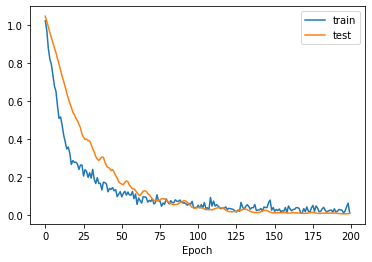

In [1062]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [955]:
num=80
norb=get_model().get_num_orbitals()
X1=np.zeros((num,nk,nk,norb*norb))
Y1=[]
Y_actual=[]
for i,j in tqdm(enumerate(np.linspace(-1,1,num))):
    my_model=get_model(delta=j,theta=np.pi/1.2)
    evec=get_wav(my_model,nk)
    X1[i]=reshape_evec(evec,phase=False)
    Y1.append(j)
    Y_actual.append(get_chern(my_model))
#[band,kpoint,orbital]

80it [00:02, 32.77it/s]


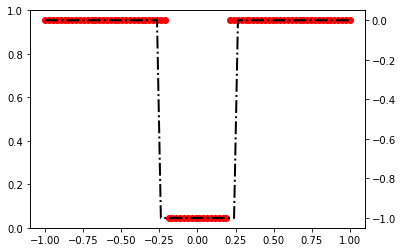

In [1022]:
fig,ax=plt.subplots()
predict=encoder.inverse_transform(model.predict(X1))
# ax.scatter(Y1,model.predict(X1).T[0],s=10,alpha=0.5)
# ax.scatter(Y1,model.predict(X1).T[1],s=10,alpha=0.5)
ax1=ax.twinx()
ax1.scatter(Y1,predict,color="red")
ax1.plot(Y1,Y_actual,c="k",ls="-.",lw=2)

In [1063]:
from tqdm.auto import tqdm as tqdm
num=50
norb=get_model().get_num_orbitals()
val=[]
val_actual=[]
theta=np.linspace(0,np.pi*2,num)
t=np.linspace(-2,2,num)
cnt=0
for i in tqdm(t, position=0):
    for j in theta:
        my_model=get_model(delta=i,theta=j)
        evec=get_wav(my_model,nk)
        test=reshape_evec(evec,phase=False)
        pred=model.predict([[test]])
        O=np.array([-1,0,1])
        val.append(np.sum(np.multiply(O,pred)))
        val_actual.append(get_chern(my_model))
#[band,kpoint,orbital]

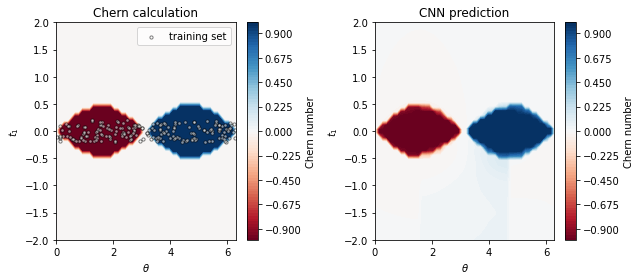

In [1071]:
fig,ax=plt.subplots(1,2,figsize=(9,4))
r=ax[1].contourf(theta,t,np.array(val).reshape(num,num),90,cmap="RdBu",vmin=-1,vmax=1)
plt.colorbar(r,ax=ax[1],label="Chern number")


r=ax[0].contourf(theta,t,np.array(val_actual).reshape(num,num),90,cmap="RdBu",vmin=-1,vmax=1)
plt.colorbar(r,ax=ax[0],label="Chern number")
ax[0].scatter(choosen_theta,choosen_t,s=10,alpha=.5,c="w",label="training set",edgecolors="k")
ax[0].legend()

ax[0].set_title("Chern calculation")
ax[1].set_title("CNN prediction")
for i in ax:
    i.set_xlabel("$\\theta$")
    i.set_ylabel("$t_1$")
plt.tight_layout()
plt.savefig("figs/CNN_model_real_imag.png",dpi=500)
plt.show()

In [1073]:
from tqdm.auto import tqdm as tqdm
num=50
norb=get_model().get_num_orbitals()
val=[]
val_actual=[]
theta=np.linspace(0,np.pi*2,num)
t=np.linspace(-2,2,num)
cnt=0
for i in tqdm(t, position=0):
    for j in theta:
        d=np.random.uniform(low=-2,high=2)
        my_model=get_model(delta=i,theta=j,d=d)
        evec=get_wav(my_model,nk)
        test=reshape_evec(evec,phase=False)
        pred=model.predict([[test]])
        O=np.array([-1,0,1])
        val.append(np.sum(np.multiply(O,pred)))
        val_actual.append(get_chern(my_model))
#[band,kpoint,orbital]

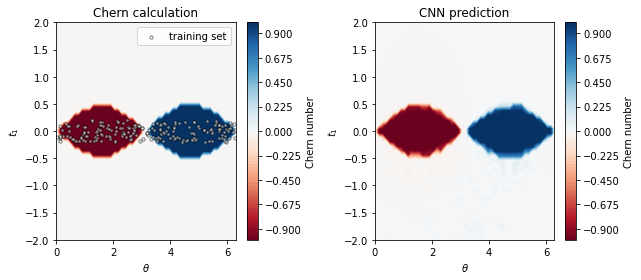

In [1074]:
fig,ax=plt.subplots(1,2,figsize=(9,4))
r=ax[1].contourf(theta,t,np.array(val).reshape(num,num),90,cmap="RdBu",vmin=-1,vmax=1)
plt.colorbar(r,ax=ax[1],label="Chern number")


r=ax[0].contourf(theta,t,np.array(val_actual).reshape(num,num),90,cmap="RdBu",vmin=-1,vmax=1)
plt.colorbar(r,ax=ax[0],label="Chern number")
ax[0].scatter(choosen_theta,choosen_t,s=10,alpha=.5,c="w",label="training set",edgecolors="k")
ax[0].legend()

ax[0].set_title("Chern calculation")
ax[1].set_title("CNN prediction")
for i in ax:
    i.set_xlabel("$\\theta$")
    i.set_ylabel("$t_1$")
plt.tight_layout()
# plt.savefig("figs/CNN_model_real_imag.png_with_d",dpi=500)
plt.show()

In [18]:
from CNN_modules import *
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [14]:
nk=10
num=90
norb=get_model().get_num_orbitals()
X=np.zeros((num,nk,nk,norb*norb))
Y=[]
choosen_t=[]
choosen_theta=[]
for i,j in tqdm(enumerate(np.linspace(0,1,num))):
    theta=np.random.uniform(low=0, high=2*np.pi)
    k=np.random.uniform(low=0, high=1)
    t=np.random.uniform(low=-.2, high=.2)
    my_model=get_model(delta=t,theta=theta)
    evec=get_wav(my_model,nk)
    X[i]=reshape_evec(evec,phase=False)
    Y.append(get_chern(my_model,k_origin=k))
    choosen_t.append(t)
    choosen_theta.append(theta)
print(Y)

90it [00:04, 20.26it/s][-1, -1, 1, -1, 0, -1, -1, 1, -1, -1, -1, -1, 0, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, -1, 0, 1, 0, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 1, 0, 1, -1, -1, -1, 0, 0, 1, -1, 1, 0, -1, -1, -1, 1, 1, 1, 0, 1, -1, -1, 1, 1, 0, 1, 0, -1, 1, 1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 0, 1, -1]



In [16]:
from sklearn.model_selection import train_test_split
import time
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
encoder,y_train = process_y(y_train)
_,y_test = process_y(y_test)
model=get_NNmodel(X_train)

start = time.time()
history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,verbose=0)
print('Processing time:',(time.time()- start)/60)

Processing time: 0.05087053378423055


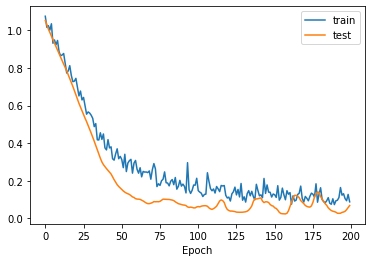

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [3]:
lat=[[1.0,0.0],[0.0,1.0]]
# define coordinates of orbitals
orb=[[0.5,0.5]]

S0=np.array([[1,0],[0,1]])
S1=np.array([[0,1],[1,0]])
S2=np.array([[0,-1j],[1j,0]])
S3=np.array([[1,0],[0,-1]])
N=np.zeros_like(S0)

Tx=(S3+1j*S1)/2
Ty=(S3+1j*S2)/2
U=-1.5*S3

In [50]:
def get_qwz_model(u):
    lat=[[1.0,0.0],[0.0,1.0]]
    orb=[[0.5,0.5]]

    S0=np.array([[1,0],[0,1]])
    S1=np.array([[0,1],[1,0]])
    S2=np.array([[0,-1j],[1j,0]])
    S3=np.array([[1,0],[0,-1]])
    N=np.zeros_like(S0)
    Tx=(S3+1j*S1)/2
    Ty=(S3+1j*S2)/2
    U=u*S3

    my_model=tb_model(2,2,lat,orb,nspin=2)
    my_model.set_onsite(U,0)
    my_model.set_hop(Tx,0,0,[1,0])
    my_model.set_hop(Ty,0,0,[0,1])
    return my_model

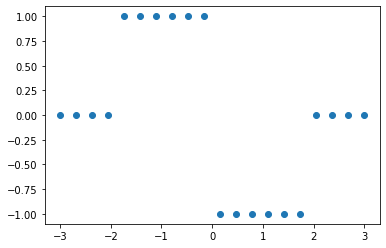

In [62]:
c=[]
for i in np.linspace(-3,3,20):
    my_model=get_qwz_model(i)
    c.append(get_chern(my_model,nk=8))
plt.scatter(np.linspace(-3,3,20),c)

In [71]:
from keras.models import load_model
model=load_model("model_cnn_periodic_100.h5")
print("Loaded model from disk")

Loaded model from disk


In [97]:
num=80
nk=10
norb=get_model().get_num_orbitals()
X1=np.zeros((num,nk,nk,norb*norb))
Y1=[]
Y_actual=[]
for i,j in tqdm(enumerate(np.linspace(-3,3,num))):
    my_model=get_qwz_model(j)
    evec=get_wav(my_model,nk)
    X1[i]=reshape_evec(evec,phase=False)
    Y1.append(j)
    Y_actual.append(get_chern(my_model))

80it [00:03, 25.71it/s]


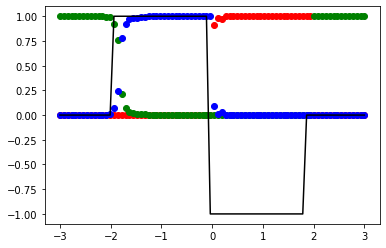

In [103]:
O=np.array([-1,0,1])
# val=[]
# for i in model.predict(X1):
#     val.append(np.sum(np.multiply(O,i)))
pred=model.predict(X1)
plt.plot(Y1,Y_actual,c="k")
plt.scatter(Y1,pred.T[0],c="r")
plt.scatter(Y1,pred.T[1],c="g")
plt.scatter(Y1,pred.T[2],c="b")

In [88]:
nk=10
num=100
Y=[]
choosen_t=[]
choosen_theta=[]


norb=get_model().get_num_orbitals()

#input wavefunctions
X=np.zeros((num*nk*nk,nk,nk,norb*norb))
cnt=0
for i,j in tqdm(enumerate(np.linspace(0,1,num))):

    #create random variable for input 
    t=np.random.uniform(low=-3, high=3)
    # solve the model for wavefunctions
    my_model=get_qwz_model(t)
    evec=get_wav(my_model,nk)
    # reshape wave functions for our Neural network input
    evec_temp=reshape_evec(evec,phase=False)
    #compute the chern number
    chern=get_chern(my_model)

    #augment data for periodicity
    for i_roll in range(nk):
        for j_roll in range(nk):
            evec_rolled=np.roll(evec_temp,i_roll,axis=0)
            evec_rolled=np.roll(evec_temp,j_roll,axis=1)
            X[cnt]=evec_rolled
            Y.append(chern)
            cnt+=1
    # get the input parameters of the training subspace
    choosen_t.append(t)




100it [00:04, 20.78it/s]


In [91]:
from CNN_modules import *
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tqdm.keras import TqdmCallback
import time

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
encoder,y_train = process_y(y_train)
_,y_test = process_y(y_test)

In [93]:
start = time.time()

history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150,verbose=0)

print('Processing time:',(time.time()- start)/60)

Processing time: 2.079741183916728


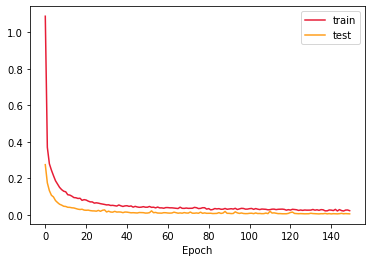

In [94]:
plt.plot(history.history['loss'], label='train',c="#e71d36")
plt.plot(history.history['val_loss'], label='test',c="#ff9f1c")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [48]:
Tx=(S3+1j*S1)/2
Ty=(S3+1j*S2)/2
U=3*S3

my_model=tb_model(2,2,lat,orb,nspin=2)
my_model.set_onsite(U,0)
my_model.set_hop(Tx,0,0,[1,0])
my_model.set_hop(Ty,0,0,[0,1])

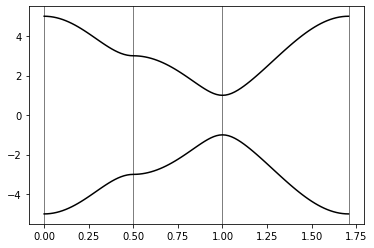

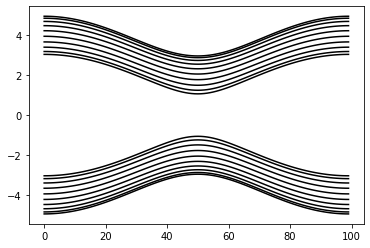

In [49]:
path=[[0.0,0.0],[0.0,0.5],[0.5,0.5],[0.0,0.0]]
label=(r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
(k_vec,k_dist,k_node)=my_model.k_path(path,101,report=0)
evals=my_model.solve_all(k_vec)
fig,ax=plt.subplots()
for i in evals:plt.plot(k_dist,i,c="k")
for n in range(len(k_node)):
  ax.axvline(x=k_node[n], linewidth=0.5, color='k')
plt.show()
edge=my_model.cut_piece(10,1,glue_edgs=False)
(k_vec,k_dist,k_node)=edge.k_path('full',100,report=False)
k_label=[r"$0$",r"$\pi$", r"$2\pi$"]

evals=edge.solve_all(k_vec)
for i in evals:
    plt.plot(i,c="k")